In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
 
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
# hyper parameter
LEARNING_RATE = 0.005
N_EPOCHS = 100
N_BATCHS = 100
N_CLASS = 10
DROPOUT_RATE = 0.3

In [3]:
label = ['비행기','자동차','새','고양이','사슴','개','개구리','말','배','트럭']
label_eng = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
# 다운로드 받는다.
(train_image, train_label), (test_image, test_label) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 3s 0us/step


In [5]:
# 32 * 32 * 3
train_image.shape, test_image.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [6]:
N_TRAIN = train_image.shape[0]
N_TEST = test_image.shape[0]

In [7]:
np.unique(train_label, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

In [8]:
train_label[:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

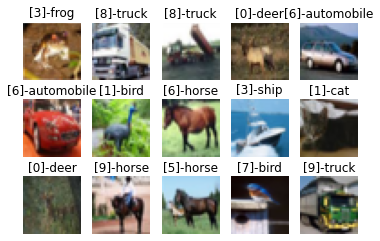

In [11]:
import matplotlib.pyplot as plt
for i in range(0,15):
    plt.subplot(3,5, i+1)
    plt.imshow(train_image[i])
    plt.axis('off')
    plt.title(f'{test_label[i]}-{label_eng[train_label[i,0]]}')
plt.show()    

# Dataset 생성

In [12]:
# pixel값을 0 ~ 1 사이로 조정
X_train = train_image.astype(np.float32)/255. # train_image/255.-->float64로 바뀌기때문에  // float32로 한 이유 :용량문제
X_test = test_image.astype(np.float32) /255.

# y - onehot encoding
y_train = keras.utils.to_categorical(train_label, num_classes=10)
y_test = keras.utils.to_categorical(test_label, 10) 

In [13]:
# dataset 구성
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
                               .shuffle(buffer_size=N_TRAIN)\
                               .batch(N_BATCHS,drop_remainder=True).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))\
                              .batch(N_BATCHS)                        

## 모델 구성

In [26]:
from tensorflow.keras import layers
def create_model():
    model = keras.Sequential()
    #Conv Layer
    model.add(layers.Input((32,32,3))) #InputLayer(input_shape=(32,32,3)) : 동일
    
    model.add(layers.Conv2D(filters=32, kernel_size=3, padding='SAME'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    model.add(layers.Conv2D(filters=32, kernel_size=3, padding='SAME'))  #(32,32,32)  패딩이 same이라 차원수만 filter때문에 늘어남..
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.MaxPooling2D(padding='SAME'))  #(16,16,32)  maxpoolimg 때문에 사이즈 줄어듦.. 

    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='SAME'))  
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='SAME'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.MaxPooling2D(padding='SAME'))
    
    model.add(layers.Conv2D(filters=128, kernel_size=3, padding='SAME'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    model.add(layers.Conv2D(filters=128, kernel_size=3, padding='SAME'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.MaxPooling2D(padding='SAME'))  #max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)  128개의 특징을 뽑고 4,4 사이즈가 됨 

 
    # Full Connected Layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(DROPOUT_RATE))
    model.add(layers.Dense(512))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())    
    model.add(layers.Dense(10, activation='softmax'))
    return model

In [27]:
# model = create_model()
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)       

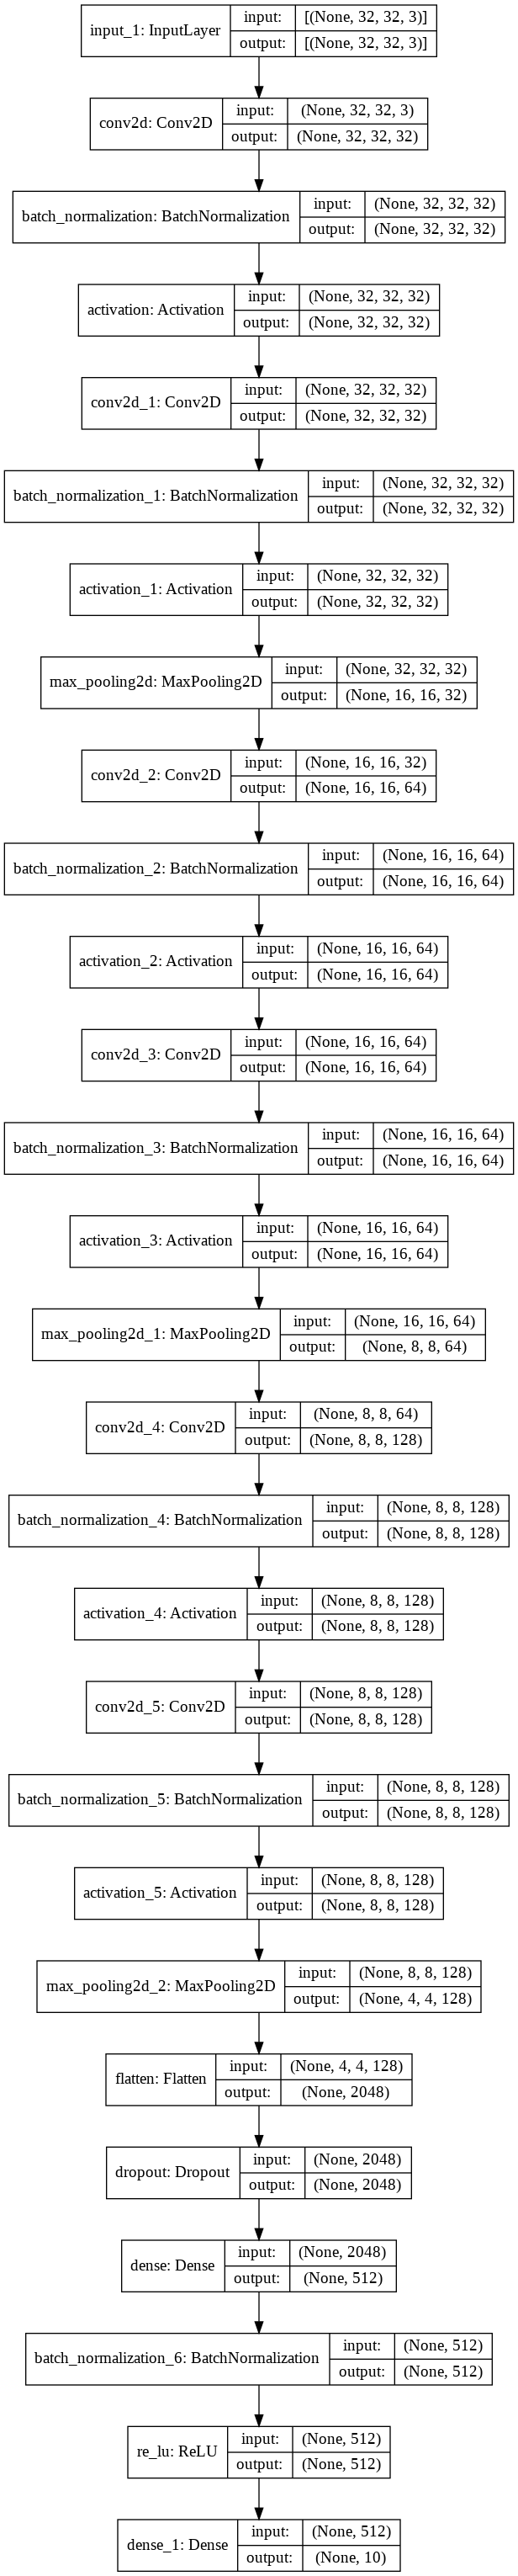

In [17]:
keras.utils.plot_model(model, to_file='model_shapes.png', show_shapes=True)

In [18]:
# 학습 전에 테스트
model.evaluate(test_dataset)

100/100 [==============================] - 33s 6ms/step - loss: 2.3032 - accuracy: 0.0939


[2.303159475326538, 0.09120000153779984]

In [19]:
# 학습시 전달할 매개변수
steps_per_epoch = N_TRAIN//N_BATCHS
validation_steps = int(np.ceil(N_TEST/N_BATCHS))
print(steps_per_epoch, validation_steps)

500 100


In [20]:
import os
base_dir = '/content/drive/MyDrive/save_models'
save_path = os.path.join(base_dir, 'cifar10_best_model')
save_path

'/content/drive/My Drive/save_models/cifar10_best_model'

In [28]:
import time
start = time.time()
modelcheckpoint_callback = keras.callbacks.ModelCheckpoint(filepath=save_path, monitor='val_loss', save_best_only=True) # 매에폭마다 저장되는것을 방지하기위해서 

history = model.fit(train_dataset, 
                    epochs=N_BATCHS,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_dataset,
                    validation_steps=validation_steps,
                    callbacks=[modelcheckpoint_callback])
end = time.time()

Epoch 1/100
500/500 [==============================] - 10s 17ms/step - loss: 1.6202 - accuracy: 0.4409 - val_loss: 1.4062 - val_accuracy: 0.5116
INFO:tensorflow:Assets written to: /content/drive/My Drive/save_models/cifar10_best_model/assets
Epoch 2/100
500/500 [==============================] - 8s 16ms/step - loss: 0.8156 - accuracy: 0.7116 - val_loss: 0.9371 - val_accuracy: 0.6873
INFO:tensorflow:Assets written to: /content/drive/My Drive/save_models/cifar10_best_model/assets
Epoch 3/100
500/500 [==============================] - 9s 17ms/step - loss: 0.6269 - accuracy: 0.7804 - val_loss: 0.7250 - val_accuracy: 0.7523
INFO:tensorflow:Assets written to: /content/drive/My Drive/save_models/cifar10_best_model/assets
Epoch 4/100
500/500 [==============================] - 8s 16ms/step - loss: 0.5035 - accuracy: 0.8269 - val_loss: 0.7991 - val_accuracy: 0.7288
Epoch 5/100
500/500 [==============================] - 8s 16ms/step - loss: 0.4190 - accuracy: 0.8548 - val_loss: 0.6756 - val_accur

In [29]:
(end-start)/60

13.804197990894318

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
saved_model = keras.models.load_model(save_path)

In [31]:
saved_model.evaluate(test_dataset)

100/100 [==============================] - 1s 6ms/step - loss: 0.6196 - accuracy: 0.7932


[0.6196115016937256, 0.7932000160217285]

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

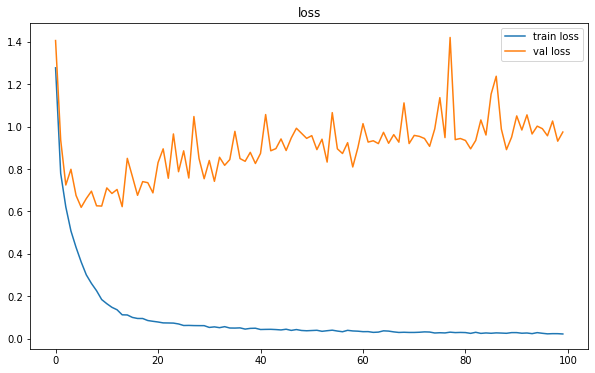

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(range(N_EPOCHS), history.history['loss'], label='train loss')
plt.plot(range(N_EPOCHS), history.history['val_loss'], label='val loss')
plt.legend()
plt.title('loss')
plt.show()

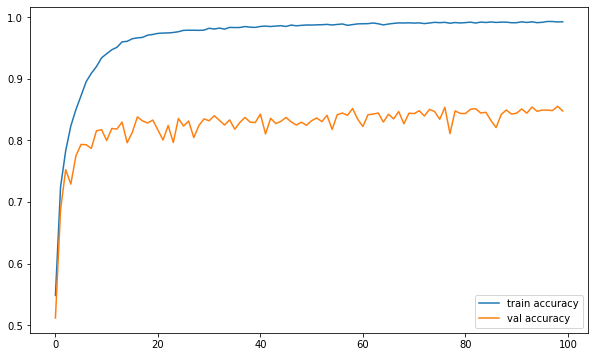

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(range(N_EPOCHS), history.history['accuracy'], label='train accuracy')
plt.plot(range(N_EPOCHS), history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

<class 'PIL.Image.Image'>


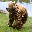

In [46]:
# 새 이미지를 모델을 이용해 추론
# 전처리 학습데이터와 동일하게 해줘야한다. (resize과 정규화 등등...)
# 정규화 (255. 나누기). 이미지 사이즈 (32,32)로 resize
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#load_img 함수 : 이미지 불러오기.
#img_to_array함수 : 불러온 이미지를 numpy 배열(ndarray)로 변환
#local에서 사용하려면 pillow를 설치해야한다. (pip install Pillow)
img_path = '/content/gom.jpg'
#img = load_img(img_path)  # 원본그대로 읽어옴.


img = load_img(img_path, target_size=(32,32)) # target_size를 지정 : 읽어올때 resize처리 한다.
print(type(img))
img

In [47]:
# ndarray로 변환
sample = img_to_array(img)
type(sample), sample.shape

(numpy.ndarray, (32, 32, 3))

In [48]:
# batch크기 축(0번축)을 늘린다. .
sample_x = sample[np.newaxis,...]
sample_x = sample_x/255.
print(sample_x.shape)
# 추론 
pred = saved_model.predict(sample_x)

(1, 32, 32, 3)


In [49]:
pred

array([[1.4378142e-04, 2.1716020e-04, 7.8443764e-03, 3.4484226e-01,
        4.1380260e-02, 1.0145045e-01, 4.9603221e-01, 7.4970834e-03,
        5.1929092e-06, 5.8719038e-04]], dtype=float32)

In [50]:
pred_class = np.argmax(pred, axis = -1)
print(pred_class, label[pred_class[0]])

[6] 개구리
